# Clasificación de Biomasa usando Machine Learning
## Clasificación de biomasa en categorías: Baja, Media, Alta

In [63]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Carga y Análisis de Datos

In [64]:
# Cargar datos
df = pd.read_excel('Base_Prediccion_Biomasa_Outliers1.xlsx', sheet_name='Datos Limpios')
print(f"Forma del dataset: {df.shape}")

# Análisis de la variable objetivo
target_col = 'Categoria de Biomasa'
print(f"\nDistribución de {target_col}:")
print(df[target_col].value_counts())
print(f"\nPorcentajes:")
print(df[target_col].value_counts(normalize=True) * 100)

df.head()

Forma del dataset: (300, 10)

Distribución de Categoria de Biomasa:
Categoria de Biomasa
Media    199
Baja      97
Alta       4
Name: count, dtype: int64

Porcentajes:
Categoria de Biomasa
Media    66.333333
Baja     32.333333
Alta      1.333333
Name: proportion, dtype: float64


,Fecha de Medicion,ID_parcela,NDVI Outlier Manual,NDRE Outlier Manual,PRECIPITACION Outlier Manual,DIAS SIN LLUVIA Estadistica,Tipo_suelo,Biomasa_real Estadistica,Categoria de Biomasa,Validacion
0,2024-01-01,P008,0.798,0.451,3.4,4.0,Arenoso,4567.8,Media,VALIDO
1,2024-01-08,P009,0.369,0.440,87.9,7.0,Arenoso,2857.5,Baja,VALIDO
2,2024-01-15,P002,0.872,0.304,24.3,4.0,Arcilloso,4812.4,Media,VALIDO
3,2024-01-22,P014,0.338,0.108,55.7,9.0,Arenoso,2442.2,Baja,VALIDO
4,2024-01-29,P014,0.866,0.391,3.9,3.0,Arenoso,6110.8,Alta,VALIDO


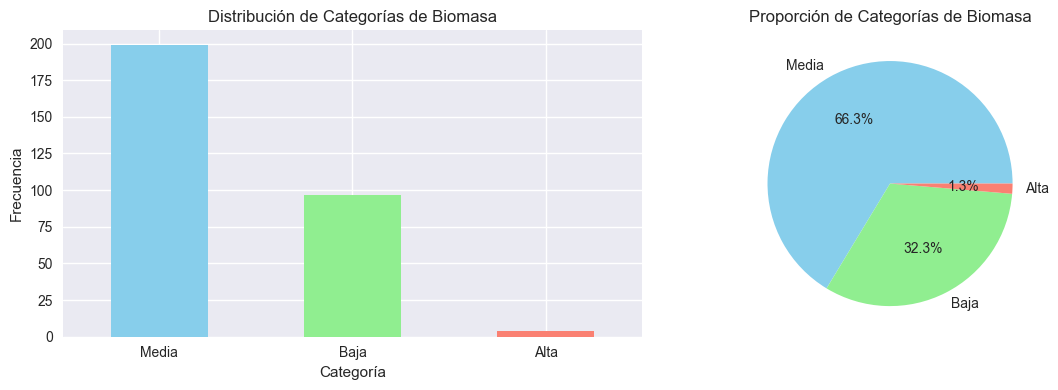

In [65]:
# Visualización de distribución de clases
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df[target_col].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribución de Categorías de Biomasa')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Proporción de Categorías de Biomasa')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 2. Preprocesamiento de Datos

In [66]:
# Preparar datos para clasificación
df_model = df.copy()

# Eliminar variables no predictoras
features_to_drop = ['Fecha de Medicion', 'ID_parcela', 'Biomasa_real Estadistica', 'Validacion']
df_model = df_model.drop(columns=features_to_drop)

# Definir variables
y = df_model[target_col]
X = df_model.drop(columns=[target_col])

print(f"Variables predictoras: {X.columns.tolist()}")
print(f"Variable objetivo: {target_col}")
print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")
print(f"\nClases únicas: {y.unique()}")

Variables predictoras: ['NDVI Outlier Manual', 'NDRE Outlier Manual', 'PRECIPITACION Outlier Manual', 'DIAS SIN LLUVIA Estadistica', 'Tipo_suelo']
Variable objetivo: Categoria de Biomasa
Forma de X: (300, 5), Forma de y: (300,)

Clases únicas: ['Media' 'Baja' 'Alta']


In [67]:
# Codificar variables categóricas en X
le_features = LabelEncoder()
categorical_features = X.select_dtypes(include=['object']).columns

for col in categorical_features:
    X[col] = le_features.fit_transform(X[col].astype(str))

# Codificar variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Codificación de clases:")
for i, clase in enumerate(le_target.classes_):
    print(f"{i}: {clase}")

print(f"\nVariables categóricas codificadas: {categorical_features.tolist()}")

Codificación de clases:
0: Alta
1: Baja
2: Media

Variables categóricas codificadas: ['Tipo_suelo']


In [68]:
# Manejo de valores nulos
print("Valores nulos antes de imputación:")
print(X.isnull().sum())

# Imputar valores nulos
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"\nDatos finales - X: {X_imputed.shape}, y: {len(y_encoded)}")
print(f"Valores nulos restantes: {X_imputed.isnull().sum().sum()}")

Valores nulos antes de imputación:
NDVI Outlier Manual              2
NDRE Outlier Manual              0
PRECIPITACION Outlier Manual     3
DIAS SIN LLUVIA Estadistica     12
Tipo_suelo                       0
dtype: int64

Datos finales - X: (300, 5), y: 300
Valores nulos restantes: 0


## 3. División de Datos y Escalado

In [69]:
# División 70/30 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Datos de entrenamiento: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Datos de prueba: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Verificar distribución estratificada
print("\nDistribución en entrenamiento:")
unique, counts = np.unique(y_train, return_counts=True)
for i, count in zip(unique, counts):
    print(f"{le_target.classes_[i]}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nDistribución en prueba:")
unique, counts = np.unique(y_test, return_counts=True)
for i, count in zip(unique, counts):
    print(f"{le_target.classes_[i]}: {count} ({count/len(y_test)*100:.1f}%)")

Datos de entrenamiento: X_train: (210, 5), y_train: (210,)
Datos de prueba: X_test: (90, 5), y_test: (90,)

Distribución en entrenamiento:
Alta: 3 (1.4%)
Baja: 68 (32.4%)
Media: 139 (66.2%)

Distribución en prueba:
Alta: 1 (1.1%)
Baja: 29 (32.2%)
Media: 60 (66.7%)


In [70]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos escalados correctamente")
print(f"Media de X_train_scaled: {X_train_scaled.mean():.6f}")
print(f"Std de X_train_scaled: {X_train_scaled.std():.6f}")

Datos escalados correctamente
Media de X_train_scaled: 0.000000
Std de X_train_scaled: 1.000000


## 4. Modelos de Clasificación

In [71]:
# Función para evaluar modelos de clasificación
def evaluate_classifier(name, model, X_train, X_test, y_train, y_test):
    """Evalúa un clasificador y retorna métricas completas"""
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas básicas
    metrics = {
        'Accuracy_train': accuracy_score(y_train, y_pred_train),
        'Accuracy_test': accuracy_score(y_test, y_pred_test),
        'Precision_test': precision_score(y_test, y_pred_test, average='weighted'),
        'Recall_test': recall_score(y_test, y_pred_test, average='weighted'),
        'F1_test': f1_score(y_test, y_pred_test, average='weighted')
    }
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    metrics['CV_Accuracy_mean'] = cv_scores.mean()
    metrics['CV_Accuracy_std'] = cv_scores.std()
    
    # AUC para multiclase (One-vs-Rest)
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)
            auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
            metrics['AUC_test'] = auc_score
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
            if y_scores.ndim == 1:  # Binario
                auc_score = roc_auc_score(y_test, y_scores)
            else:  # Multiclase
                auc_score = roc_auc_score(y_test, y_scores, multi_class='ovr', average='weighted')
            metrics['AUC_test'] = auc_score
        else:
            metrics['AUC_test'] = np.nan
    except:
        metrics['AUC_test'] = np.nan
    
    return metrics, y_pred_test

# Diccionario para almacenar resultados
results_clf = {}

### 4.1 Support Vector Machine (SVM)

In [72]:
# SVM con kernel linear
svm_linear_params = {'C': [0.1, 1, 10, 100]}
svm_linear = GridSearchCV(SVC(kernel='linear', random_state=42), svm_linear_params, cv=5, scoring='accuracy')
svm_linear_metrics, svm_linear_pred = evaluate_classifier('SVM Linear', svm_linear, X_train_scaled, X_test_scaled, y_train, y_test)
results_clf['SVM Linear'] = svm_linear_metrics

print("=== SVM LINEAR ===")
print(f"Mejor C: {svm_linear.best_params_['C']}")
for metric, value in svm_linear_metrics.items():
    print(f"{metric}: {value:.4f}")

=== SVM LINEAR ===
Mejor C: 10
Accuracy_train: 0.8667
Accuracy_test: 0.8667
Precision_test: 0.8561
Recall_test: 0.8667
F1_test: 0.8611
CV_Accuracy_mean: 0.8476
CV_Accuracy_std: 0.0190
AUC_test: nan


In [73]:
# SVM con kernel RBF
svm_rbf_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}
svm_rbf = GridSearchCV(SVC(kernel='rbf', random_state=42), svm_rbf_params, cv=5, scoring='accuracy')
svm_rbf_metrics, svm_rbf_pred = evaluate_classifier('SVM RBF', svm_rbf, X_train_scaled, X_test_scaled, y_train, y_test)
results_clf['SVM RBF'] = svm_rbf_metrics

print("\n=== SVM RBF ===")
print(f"Mejores parámetros: {svm_rbf.best_params_}")
for metric, value in svm_rbf_metrics.items():
    print(f"{metric}: {value:.4f}")


=== SVM RBF ===
Mejores parámetros: {'C': 10, 'gamma': 0.01}
Accuracy_train: 0.8714
Accuracy_test: 0.8667
Precision_test: 0.8560
Recall_test: 0.8667
F1_test: 0.8599
CV_Accuracy_mean: 0.8571
CV_Accuracy_std: 0.0337
AUC_test: nan


In [74]:
# SVM con kernel polynomial
svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}
svm_poly = GridSearchCV(SVC(kernel='poly', random_state=42), svm_poly_params, cv=5, scoring='accuracy')
svm_poly_metrics, svm_poly_pred = evaluate_classifier('SVM Polynomial', svm_poly, X_train_scaled, X_test_scaled, y_train, y_test)
results_clf['SVM Polynomial'] = svm_poly_metrics

print("\n=== SVM POLYNOMIAL ===")
print(f"Mejores parámetros: {svm_poly.best_params_}")
for metric, value in svm_poly_metrics.items():
    print(f"{metric}: {value:.4f}")


=== SVM POLYNOMIAL ===
Mejores parámetros: {'C': 1, 'degree': 3, 'gamma': 'scale'}
Accuracy_train: 0.8714
Accuracy_test: 0.8444
Precision_test: 0.8424
Recall_test: 0.8444
F1_test: 0.8316
CV_Accuracy_mean: 0.8286
CV_Accuracy_std: 0.0462
AUC_test: nan


### 4.2 Random Forest Classifier

In [75]:
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_metrics, rf_pred = evaluate_classifier('Random Forest', rf_clf, X_train, X_test, y_train, y_test)
results_clf['Random Forest'] = rf_metrics

print("=== RANDOM FOREST ===")
print(f"Mejores parámetros: {rf_clf.best_params_}")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

# Importancia de características
feature_importance = pd.DataFrame({
    'feature': X_imputed.columns,
    'importance': rf_clf.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportancia de características:")
print(feature_importance)

=== RANDOM FOREST ===
Mejores parámetros: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy_train: 0.8905
Accuracy_test: 0.8667
Precision_test: 0.8616
Recall_test: 0.8667
F1_test: 0.8569
CV_Accuracy_mean: 0.8762
CV_Accuracy_std: 0.0462
AUC_test: 0.8802

Importancia de características:
                        feature  importance
0           NDVI Outlier Manual    0.718419
2  PRECIPITACION Outlier Manual    0.113087
1           NDRE Outlier Manual    0.078713
3   DIAS SIN LLUVIA Estadistica    0.074646
4                    Tipo_suelo    0.015135


### 4.3 Gradient Boosting Classifier

In [76]:
# Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy')
gb_metrics, gb_pred = evaluate_classifier('Gradient Boosting', gb_clf, X_train, X_test, y_train, y_test)
results_clf['Gradient Boosting'] = gb_metrics

print("=== GRADIENT BOOSTING ===")
print(f"Mejores parámetros: {gb_clf.best_params_}")
for metric, value in gb_metrics.items():
    print(f"{metric}: {value:.4f}")

=== GRADIENT BOOSTING ===
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Accuracy_train: 0.8952
Accuracy_test: 0.8444
Precision_test: 0.8424
Recall_test: 0.8444
F1_test: 0.8316
CV_Accuracy_mean: 0.8571
CV_Accuracy_std: 0.0452
AUC_test: 0.8949


### 4.4 Logistic Regression

In [77]:
# Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
lr_clf = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), lr_params, cv=5, scoring='accuracy')
lr_metrics, lr_pred = evaluate_classifier('Logistic Regression', lr_clf, X_train_scaled, X_test_scaled, y_train, y_test)
results_clf['Logistic Regression'] = lr_metrics

print("=== LOGISTIC REGRESSION ===")
print(f"Mejores parámetros: {lr_clf.best_params_}")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

=== LOGISTIC REGRESSION ===
Mejores parámetros: {'C': 0.1, 'solver': 'lbfgs'}
Accuracy_train: 0.8667
Accuracy_test: 0.8778
Precision_test: 0.8671
Recall_test: 0.8778
F1_test: 0.8717
CV_Accuracy_mean: 0.8571
CV_Accuracy_std: 0.0301
AUC_test: 0.9224


### 4.5 Decision Tree Classifier

In [78]:
# Decision Tree
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_clf = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_metrics, dt_pred = evaluate_classifier('Decision Tree', dt_clf, X_train, X_test, y_train, y_test)
results_clf['Decision Tree'] = dt_metrics

print("=== DECISION TREE ===")
print(f"Mejores parámetros: {dt_clf.best_params_}")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value:.4f}")

=== DECISION TREE ===
Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Accuracy_train: 0.9095
Accuracy_test: 0.8111
Precision_test: 0.8207
Recall_test: 0.8111
F1_test: 0.8159
CV_Accuracy_mean: 0.8429
CV_Accuracy_std: 0.0490
AUC_test: 0.8882


### 4.6 K-Nearest Neighbors

In [79]:
# K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_metrics, knn_pred = evaluate_classifier('KNN', knn_clf, X_train_scaled, X_test_scaled, y_train, y_test)
results_clf['KNN'] = knn_metrics

print("=== K-NEAREST NEIGHBORS ===")
print(f"Mejores parámetros: {knn_clf.best_params_}")
for metric, value in knn_metrics.items():
    print(f"{metric}: {value:.4f}")

=== K-NEAREST NEIGHBORS ===
Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy_train: 0.8714
Accuracy_test: 0.8444
Precision_test: 0.8332
Recall_test: 0.8444
F1_test: 0.8375
CV_Accuracy_mean: 0.7905
CV_Accuracy_std: 0.0278
AUC_test: 0.8995


### 4.7 Naive Bayes

In [80]:
# Naive Bayes
nb_clf = GaussianNB()
nb_metrics, nb_pred = evaluate_classifier('Naive Bayes', nb_clf, X_train_scaled, X_test_scaled, y_train, y_test)
results_clf['Naive Bayes'] = nb_metrics

print("=== NAIVE BAYES ===")
for metric, value in nb_metrics.items():
    print(f"{metric}: {value:.4f}")

=== NAIVE BAYES ===
Accuracy_train: 0.8429
Accuracy_test: 0.8556
Precision_test: 0.8457
Recall_test: 0.8556
F1_test: 0.8506
CV_Accuracy_mean: 0.8429
CV_Accuracy_std: 0.0415
AUC_test: 0.9340


## 5. Comparación de Modelos

In [81]:
# Crear DataFrame con resultados
results_df_clf = pd.DataFrame(results_clf).T
results_df_clf = results_df_clf.round(4)

print("=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===")
print(results_df_clf)

# Ordenar por accuracy de test
results_sorted_clf = results_df_clf.sort_values('Accuracy_test', ascending=False)
print("\n=== RANKING POR ACCURACY DE TEST ===")
print(results_sorted_clf[['Accuracy_test', 'Precision_test', 'Recall_test', 'F1_test', 'CV_Accuracy_mean']])

=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===
                     Accuracy_train  Accuracy_test  Precision_test  \
SVM Linear                   0.8667         0.8667          0.8561   
SVM RBF                      0.8714         0.8667          0.8560   
SVM Polynomial               0.8714         0.8444          0.8424   
Random Forest                0.8905         0.8667          0.8616   
Gradient Boosting            0.8952         0.8444          0.8424   
Logistic Regression          0.8667         0.8778          0.8671   
Decision Tree                0.9095         0.8111          0.8207   
KNN                          0.8714         0.8444          0.8332   
Naive Bayes                  0.8429         0.8556          0.8457   

                     Recall_test  F1_test  CV_Accuracy_mean  CV_Accuracy_std  \
SVM Linear                0.8667   0.8611            0.8476           0.0190   
SVM RBF                   0.8667   0.8599            0.8571           0.0337   
SVM Polynom

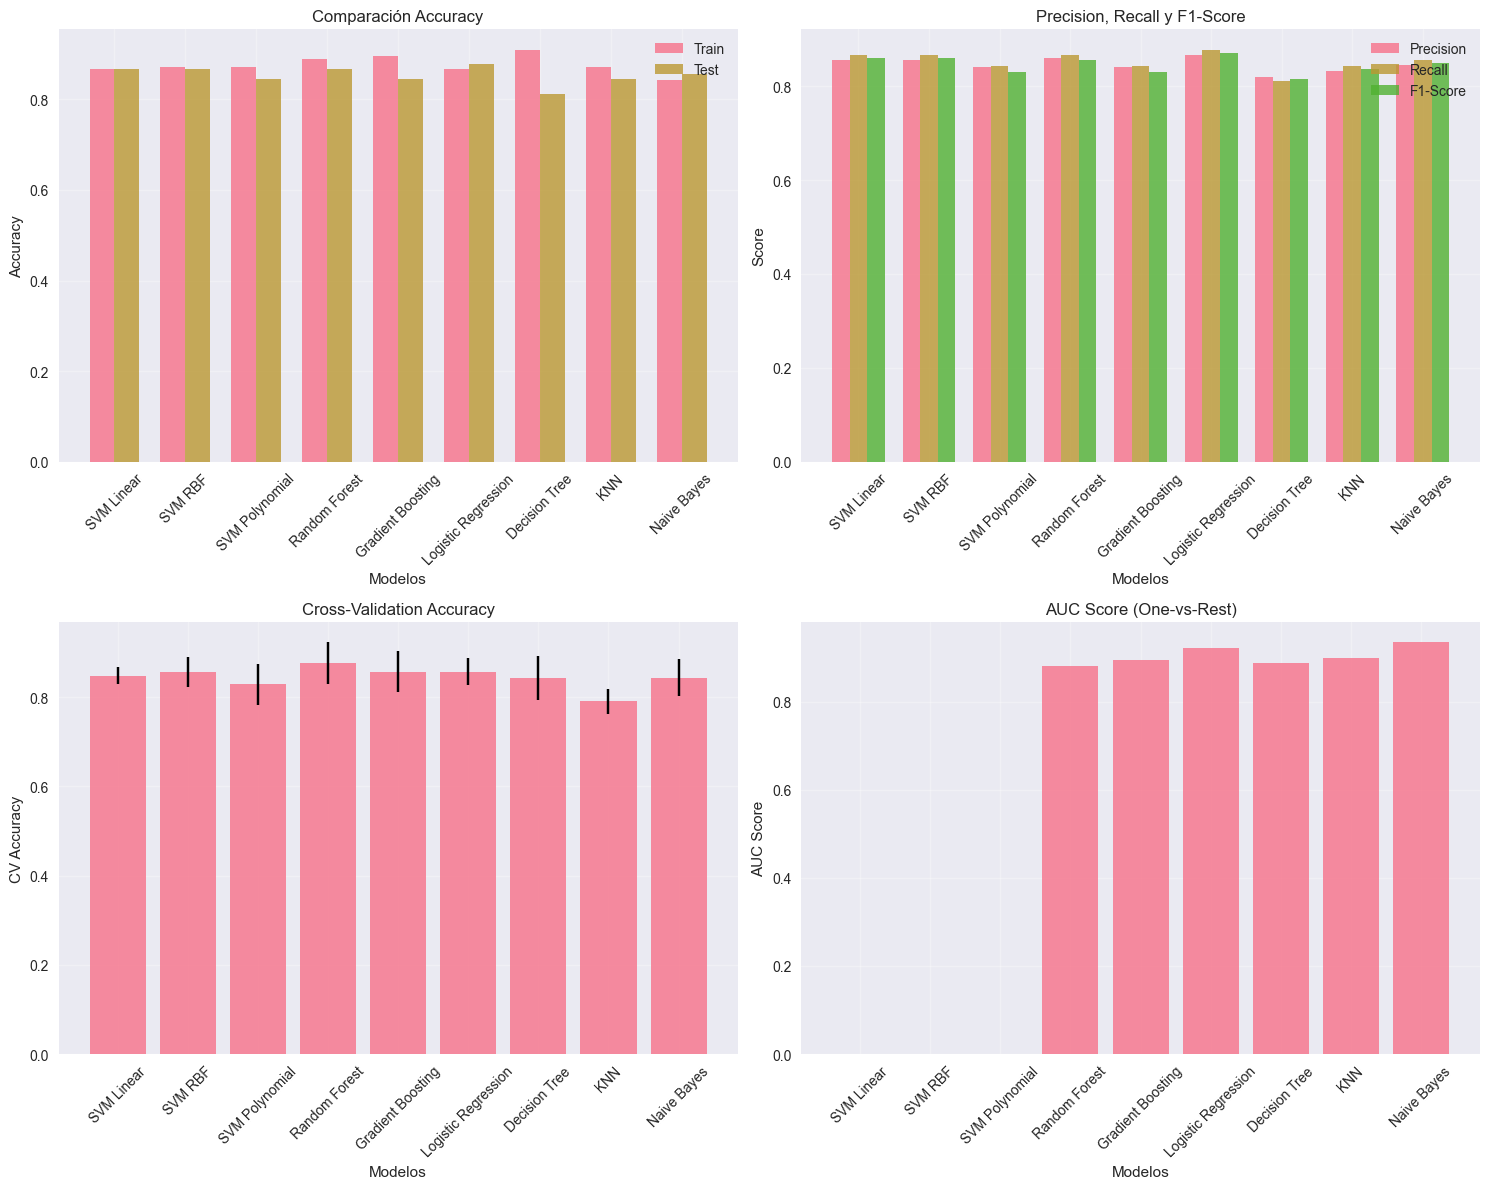

In [82]:
# Visualización de comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

models = list(results_clf.keys())
accuracy_train = [results_clf[model]['Accuracy_train'] for model in models]
accuracy_test = [results_clf[model]['Accuracy_test'] for model in models]

x = np.arange(len(models))
width = 0.35

# Accuracy
axes[0,0].bar(x - width/2, accuracy_train, width, label='Train', alpha=0.8)
axes[0,0].bar(x + width/2, accuracy_test, width, label='Test', alpha=0.8)
axes[0,0].set_xlabel('Modelos')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_title('Comparación Accuracy')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Precision, Recall, F1
precision_test = [results_clf[model]['Precision_test'] for model in models]
recall_test = [results_clf[model]['Recall_test'] for model in models]
f1_test = [results_clf[model]['F1_test'] for model in models]

width = 0.25
axes[0,1].bar(x - width, precision_test, width, label='Precision', alpha=0.8)
axes[0,1].bar(x, recall_test, width, label='Recall', alpha=0.8)
axes[0,1].bar(x + width, f1_test, width, label='F1-Score', alpha=0.8)
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('Score')
axes[0,1].set_title('Precision, Recall y F1-Score')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(models, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Cross-validation Accuracy
cv_accuracy_mean = [results_clf[model]['CV_Accuracy_mean'] for model in models]
cv_accuracy_std = [results_clf[model]['CV_Accuracy_std'] for model in models]

axes[1,0].bar(x, cv_accuracy_mean, yerr=cv_accuracy_std, capsize=5, alpha=0.8)
axes[1,0].set_xlabel('Modelos')
axes[1,0].set_ylabel('CV Accuracy')
axes[1,0].set_title('Cross-Validation Accuracy')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# AUC Score
auc_test = [results_clf[model]['AUC_test'] if not np.isnan(results_clf[model]['AUC_test']) else 0 for model in models]
axes[1,1].bar(x, auc_test, alpha=0.8)
axes[1,1].set_xlabel('Modelos')
axes[1,1].set_ylabel('AUC Score')
axes[1,1].set_title('AUC Score (One-vs-Rest)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models, rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análisis Detallado del Mejor Modelo

In [83]:
# Identificar el mejor modelo
best_model_name = results_sorted_clf.index[0]
print(f"Mejor modelo: {best_model_name}")
print(f"Accuracy de test: {results_sorted_clf.loc[best_model_name, 'Accuracy_test']:.4f}")
print(f"F1-Score de test: {results_sorted_clf.loc[best_model_name, 'F1_test']:.4f}")

# Obtener predicciones del mejor modelo
if best_model_name == 'SVM Linear':
    best_predictions = svm_linear_pred
    best_model = svm_linear
elif best_model_name == 'SVM RBF':
    best_predictions = svm_rbf_pred
    best_model = svm_rbf
elif best_model_name == 'SVM Polynomial':
    best_predictions = svm_poly_pred
    best_model = svm_poly
elif best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf_clf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb_clf
elif best_model_name == 'Logistic Regression':
    best_predictions = lr_pred
    best_model = lr_clf
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt_clf
elif best_model_name == 'KNN':
    best_predictions = knn_pred
    best_model = knn_clf
else:  # Naive Bayes
    best_predictions = nb_pred
    best_model = nb_clf

Mejor modelo: Logistic Regression
Accuracy de test: 0.8778
F1-Score de test: 0.8717


### 6.1 Matriz de Confusión

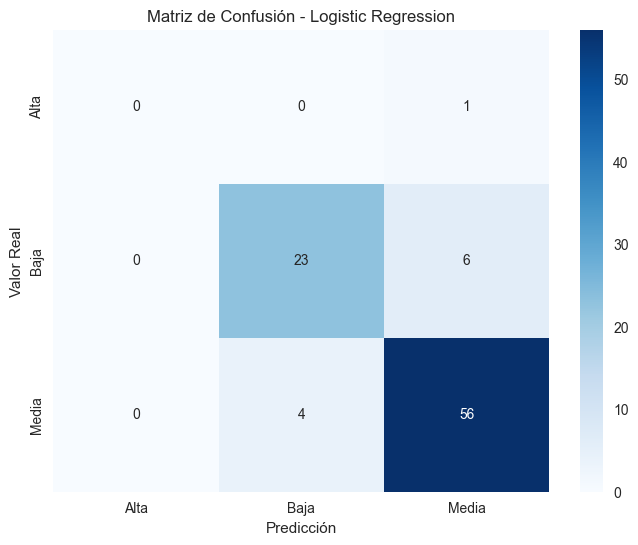


=== MÉTRICAS DETALLADAS - Logistic Regression ===
              precision    recall  f1-score   support

        Alta       0.00      0.00      0.00         1
        Baja       0.85      0.79      0.82        29
       Media       0.89      0.93      0.91        60

    accuracy                           0.88        90
   macro avg       0.58      0.58      0.58        90
weighted avg       0.87      0.88      0.87        90



In [84]:
# Matriz de confusión
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Calcular métricas por clase
print(f"\n=== MÉTRICAS DETALLADAS - {best_model_name} ===")
print(classification_report(y_test, best_predictions, target_names=le_target.classes_))

### 6.2 Métricas de Error Detalladas

In [85]:
# Métricas de error por clase
precision_per_class = precision_score(y_test, best_predictions, average=None)
recall_per_class = recall_score(y_test, best_predictions, average=None)
f1_per_class = f1_score(y_test, best_predictions, average=None)

metrics_per_class = pd.DataFrame({
    'Clase': le_target.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

print("=== MÉTRICAS POR CLASE ===")
print(metrics_per_class.round(4))

# Errores de clasificación
errors = (y_test != best_predictions)
error_rate = errors.sum() / len(y_test)
print(f"\nTasa de error: {error_rate:.4f} ({error_rate*100:.2f}%)")
print(f"Errores totales: {errors.sum()} de {len(y_test)} muestras")

=== MÉTRICAS POR CLASE ===
   Clase  Precision  Recall  F1-Score
0   Alta     0.0000  0.0000    0.0000
1   Baja     0.8519  0.7931    0.8214
2  Media     0.8889  0.9333    0.9106

Tasa de error: 0.1222 (12.22%)
Errores totales: 11 de 90 muestras


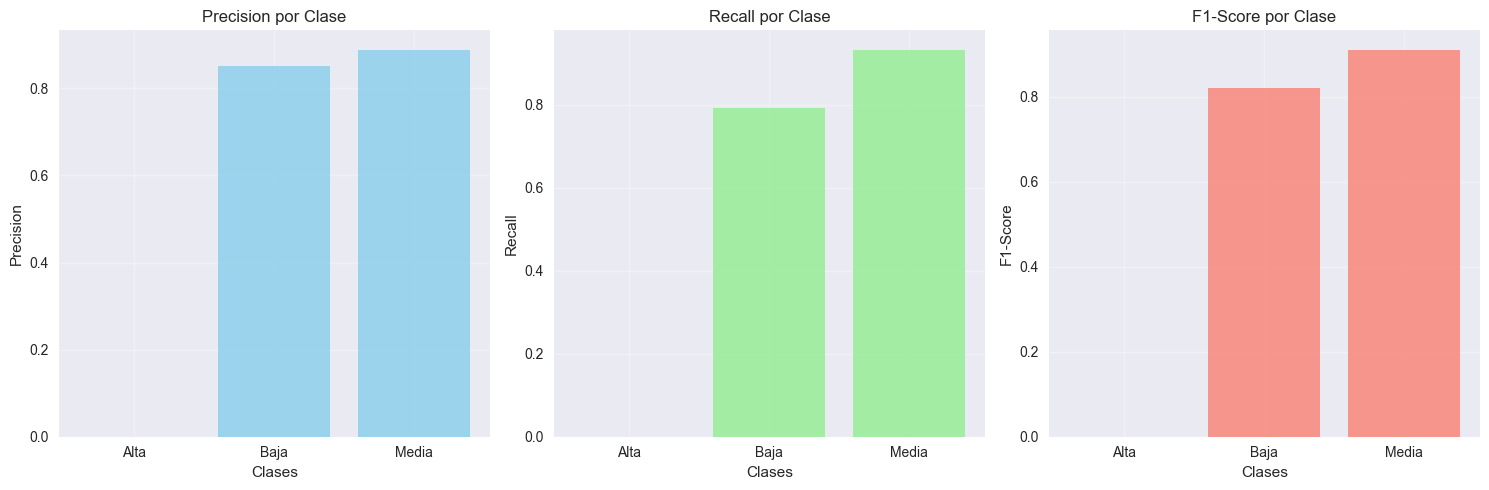

In [86]:
# Visualización de métricas por clase
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

classes = le_target.classes_
x_pos = np.arange(len(classes))

# Precision
axes[0].bar(x_pos, precision_per_class, alpha=0.8, color='skyblue')
axes[0].set_xlabel('Clases')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision por Clase')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(classes)
axes[0].grid(True, alpha=0.3)

# Recall
axes[1].bar(x_pos, recall_per_class, alpha=0.8, color='lightgreen')
axes[1].set_xlabel('Clases')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall por Clase')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(classes)
axes[1].grid(True, alpha=0.3)

# F1-Score
axes[2].bar(x_pos, f1_per_class, alpha=0.8, color='salmon')
axes[2].set_xlabel('Clases')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score por Clase')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(classes)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Análisis de Características (si aplica)

In [87]:
# Si el mejor modelo es Random Forest o tiene feature importances
if best_model_name == 'Random Forest':
    print("=== IMPORTANCIA DE CARACTERÍSTICAS - RANDOM FOREST ===")
    
    # Gráfico de importancia
    plt.figure(figsize=(10, 6))
    feature_importance_sorted = feature_importance.sort_values('importance', ascending=True)
    plt.barh(range(len(feature_importance_sorted)), feature_importance_sorted['importance'])
    plt.yticks(range(len(feature_importance_sorted)), feature_importance_sorted['feature'])
    plt.xlabel('Importancia')
    plt.title('Importancia de Características - Random Forest')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(feature_importance)

elif best_model_name == 'Gradient Boosting':
    print("=== IMPORTANCIA DE CARACTERÍSTICAS - GRADIENT BOOSTING ===")
    gb_importance = pd.DataFrame({
        'feature': X_imputed.columns,
        'importance': gb_clf.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    gb_importance_sorted = gb_importance.sort_values('importance', ascending=True)
    plt.barh(range(len(gb_importance_sorted)), gb_importance_sorted['importance'])
    plt.yticks(range(len(gb_importance_sorted)), gb_importance_sorted['feature'])
    plt.xlabel('Importancia')
    plt.title('Importancia de Características - Gradient Boosting')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(gb_importance)

## 8. Resumen y Conclusiones

In [88]:
print("=== RESUMEN FINAL - CLASIFICACIÓN DE BIOMASA ===")
print(f"Dataset: {df.shape[0]} filas, {len(X_imputed.columns)} variables predictoras")
print(f"Clases: {', '.join(le_target.classes_)}")
print(f"División: {len(y_train)} entrenamiento, {len(y_test)} prueba")

print(f"\nMejor modelo: {best_model_name}")
print(f"Accuracy: {results_sorted_clf.loc[best_model_name, 'Accuracy_test']:.4f}")
print(f"Precision: {results_sorted_clf.loc[best_model_name, 'Precision_test']:.4f}")
print(f"Recall: {results_sorted_clf.loc[best_model_name, 'Recall_test']:.4f}")
print(f"F1-Score: {results_sorted_clf.loc[best_model_name, 'F1_test']:.4f}")

print("\n=== TOP 3 MODELOS ===")
for i, (model_name, metrics) in enumerate(results_sorted_clf.head(3).iterrows()):
    print(f"{i+1}. {model_name}: Accuracy={metrics['Accuracy_test']:.4f}, F1={metrics['F1_test']:.4f}")

print("\n=== DISTRIBUCIÓN DE ERRORES POR CLASE ===")
for i, clase in enumerate(le_target.classes_):
    class_errors = ((y_test == i) & (best_predictions != i)).sum()
    class_total = (y_test == i).sum()
    if class_total > 0:
        error_rate_class = class_errors / class_total
        print(f"{clase}: {class_errors}/{class_total} errores ({error_rate_class*100:.1f}%)")

print(f"\nError total: {errors.sum()}/{len(y_test)} ({error_rate*100:.2f}%)")
print(f"Exactitud total: {(1-error_rate)*100:.2f}%")

=== RESUMEN FINAL - CLASIFICACIÓN DE BIOMASA ===
Dataset: 300 filas, 5 variables predictoras
Clases: Alta, Baja, Media
División: 210 entrenamiento, 90 prueba

Mejor modelo: Logistic Regression
Accuracy: 0.8778
Precision: 0.8671
Recall: 0.8778
F1-Score: 0.8717

=== TOP 3 MODELOS ===
1. Logistic Regression: Accuracy=0.8778, F1=0.8717
2. SVM Linear: Accuracy=0.8667, F1=0.8611
3. SVM RBF: Accuracy=0.8667, F1=0.8599

=== DISTRIBUCIÓN DE ERRORES POR CLASE ===
Alta: 1/1 errores (100.0%)
Baja: 6/29 errores (20.7%)
Media: 4/60 errores (6.7%)

Error total: 11/90 (12.22%)
Exactitud total: 87.78%


## 9. Generación Automatizada de Reportes en Excel

In [89]:
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Crear reporte Excel automatizado para clasificación
def generar_reporte_excel_clasificacion(best_model_name=None, best_predictions=None, results_sorted=None,
                         y_test=None, X_train=None, X_test=None, df=None, X_imputed=None, le_target=None):
    """Genera un reporte completo en Excel con todos los resultados del análisis de clasificación"""

    # Nombre del archivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'Reporte_Clasificacion_Biomasa_{timestamp}.xlsx'

    # Crear workbook
    wb = Workbook()

    # Estilos
    header_fill = PatternFill(start_color="4CAF50", end_color="4CAF50", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", size=12)
    title_font = Font(bold=True, size=14, color="1F4788")
    border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    # ============ HOJA 1: RESUMEN EJECUTIVO ============
    ws1 = wb.active
    ws1.title = "Resumen Ejecutivo"

    # Título
    ws1['A1'] = 'REPORTE DE CLASIFICACIÓN DE BIOMASA - MACHINE LEARNING'
    ws1['A1'].font = Font(bold=True, size=16, color="1F4788")
    ws1.merge_cells('A1:D1')

    ws1['A2'] = f'Fecha de generación: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
    ws1['A2'].font = Font(italic=True)
    ws1.merge_cells('A2:D2')

    # Información del dataset
    row = 4
    ws1[f'A{row}'] = 'INFORMACIÓN DEL DATASET'
    ws1[f'A{row}'].font = title_font
    row += 1

    dataset_info = [
        ['Total de registros:', df.shape[0]],
        ['Registros válidos para modelado:', X_imputed.shape[0]],
        ['Variables predictoras:', X_imputed.shape[1]],
        ['Clases objetivo:', ', '.join(le_target.classes_)],
        ['División entrenamiento:', f'{X_train.shape[0]} ({X_train.shape[0]/X_imputed.shape[0]*100:.1f}%)'],
        ['División prueba:', f'{X_test.shape[0]} ({X_test.shape[0]/X_imputed.shape[0]*100:.1f}%)'],
    ]

    for item in dataset_info:
        ws1[f'A{row}'] = item[0]
        ws1[f'B{row}'] = item[1]
        ws1[f'A{row}'].font = Font(bold=True)
        row += 1

    # Mejor modelo
    row += 2
    ws1[f'A{row}'] = 'MEJOR MODELO SELECCIONADO'
    ws1[f'A{row}'].font = title_font
    row += 1

    ws1[f'A{row}'] = 'Modelo:'
    ws1[f'B{row}'] = best_model_name
    ws1[f'A{row}'].font = Font(bold=True)
    ws1[f'B{row}'].font = Font(bold=True, size=12, color="006400")
    row += 1

    best_model_info = [
        ['Accuracy (Test):', f"{results_sorted.loc[best_model_name, 'Accuracy_test']:.4f}"],
        ['Precision (Test):', f"{results_sorted.loc[best_model_name, 'Precision_test']:.4f}"],
        ['Recall (Test):', f"{results_sorted.loc[best_model_name, 'Recall_test']:.4f}"],
        ['F1-Score (Test):', f"{results_sorted.loc[best_model_name, 'F1_test']:.4f}"],
        ['CV Accuracy Media:', f"{results_sorted.loc[best_model_name, 'CV_Accuracy_mean']:.4f}"],
    ]

    for item in best_model_info:
        ws1[f'A{row}'] = item[0]
        ws1[f'B{row}'] = item[1]
        ws1[f'A{row}'].font = Font(bold=True)
        row += 1

    # Top 3 modelos
    row += 2
    ws1[f'A{row}'] = 'TOP 3 MODELOS'
    ws1[f'A{row}'].font = title_font
    row += 1

    # Encabezados
    headers = ['Ranking', 'Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    for col, header in enumerate(headers, start=1):
        cell = ws1.cell(row=row, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border
    row += 1

    # Datos top 3
    for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows(), start=1):
        ws1[f'A{row}'] = i
        ws1[f'B{row}'] = model_name
        ws1[f'C{row}'] = f"{metrics['Accuracy_test']:.4f}"
        ws1[f'D{row}'] = f"{metrics['Precision_test']:.4f}"
        ws1[f'E{row}'] = f"{metrics['Recall_test']:.4f}"
        ws1[f'F{row}'] = f"{metrics['F1_test']:.4f}"

        for col in range(1, 7):
            ws1.cell(row=row, column=col).border = border
            ws1.cell(row=row, column=col).alignment = Alignment(horizontal='center')
        row += 1

    # Ajustar anchos
    ws1.column_dimensions['A'].width = 25
    ws1.column_dimensions['B'].width = 25
    ws1.column_dimensions['C'].width = 15
    ws1.column_dimensions['D'].width = 15
    ws1.column_dimensions['E'].width = 15
    ws1.column_dimensions['F'].width = 15

    # ============ HOJA 2: COMPARACIÓN DE MODELOS ============
    ws2 = wb.create_sheet("Comparación Modelos")

    ws2['A1'] = 'COMPARACIÓN DETALLADA DE MODELOS DE CLASIFICACIÓN'
    ws2['A1'].font = title_font
    ws2.merge_cells('A1:I1')

    # Encabezados
    headers = ['Modelo', 'Acc Train', 'Acc Test', 'Precision', 'Recall', 
               'F1-Score', 'CV Acc Mean', 'CV Acc Std', 'AUC']
    for col, header in enumerate(headers, start=1):
        cell = ws2.cell(row=3, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border

    # Datos
    row = 4
    for model_name, metrics in results_sorted.iterrows():
        ws2[f'A{row}'] = model_name
        ws2[f'B{row}'] = f"{metrics['Accuracy_train']:.4f}"
        ws2[f'C{row}'] = f"{metrics['Accuracy_test']:.4f}"
        ws2[f'D{row}'] = f"{metrics['Precision_test']:.4f}"
        ws2[f'E{row}'] = f"{metrics['Recall_test']:.4f}"
        ws2[f'F{row}'] = f"{metrics['F1_test']:.4f}"
        ws2[f'G{row}'] = f"{metrics['CV_Accuracy_mean']:.4f}"
        ws2[f'H{row}'] = f"{metrics['CV_Accuracy_std']:.4f}"
        if not np.isnan(metrics['AUC_test']):
            ws2[f'I{row}'] = f"{metrics['AUC_test']:.4f}"
        else:
            ws2[f'I{row}'] = 'N/A'

        # Resaltar mejor modelo
        if model_name == best_model_name:
            for col in range(1, 10):
                ws2.cell(row=row, column=col).fill = PatternFill(
                    start_color="C6EFCE", end_color="C6EFCE", fill_type="solid"
                )

        for col in range(1, 10):
            ws2.cell(row=row, column=col).border = border
            ws2.cell(row=row, column=col).alignment = Alignment(horizontal='center')
        row += 1

    # Ajustar anchos
    for col in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
        ws2.column_dimensions[col].width = 15

    # ============ HOJA 3: PREDICCIONES Y MATRIZ DE CONFUSIÓN ============
    ws3 = wb.create_sheet("Predicciones")

    ws3['A1'] = 'PREDICCIONES DEL MEJOR MODELO'
    ws3['A1'].font = title_font
    ws3.merge_cells('A1:D1')

    ws3['A2'] = f'Modelo: {best_model_name}'
    ws3['A2'].font = Font(bold=True)
    ws3.merge_cells('A2:D2')

    # Crear DataFrame con predicciones
    predicciones_df = pd.DataFrame({
        'ID': range(1, len(y_test) + 1),
        'Clase Real': [le_target.classes_[i] for i in y_test],
        'Clase Predicha': [le_target.classes_[i] for i in best_predictions],
        'Correcto': ['Sí' if y_test[i] == best_predictions[i] else 'No' for i in range(len(y_test))]
    })

    # Encabezados
    row = 4
    for col, header in enumerate(predicciones_df.columns, start=1):
        cell = ws3.cell(row=row, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border

    # Datos
    for r_idx, row_data in enumerate(dataframe_to_rows(predicciones_df, index=False, header=False), start=5):
        for c_idx, value in enumerate(row_data, start=1):
            cell = ws3.cell(row=r_idx, column=c_idx)
            cell.value = value
            cell.border = border
            cell.alignment = Alignment(horizontal='center')

            # Colorear según si es correcto
            if c_idx == 4:  # Columna Correcto
                if value == 'Sí':
                    cell.fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")
                else:
                    cell.fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")

    # Estadísticas
    stats_row = len(predicciones_df) + 7
    ws3[f'A{stats_row}'] = 'ESTADÍSTICAS DE CLASIFICACIÓN'
    ws3[f'A{stats_row}'].font = title_font

    stats_row += 1
    total_correcto = (predicciones_df['Correcto'] == 'Sí').sum()
    total = len(predicciones_df)
    accuracy = total_correcto / total

    error_stats = [
        ['Total de muestras:', total],
        ['Predicciones correctas:', total_correcto],
        ['Predicciones incorrectas:', total - total_correcto],
        ['Accuracy:', f"{accuracy:.4f} ({accuracy*100:.2f}%)"],
        ['Precision:', f"{results_sorted.loc[best_model_name, 'Precision_test']:.4f}"],
        ['Recall:', f"{results_sorted.loc[best_model_name, 'Recall_test']:.4f}"],
        ['F1-Score:', f"{results_sorted.loc[best_model_name, 'F1_test']:.4f}"],
    ]

    for item in error_stats:
        ws3[f'A{stats_row}'] = item[0]
        ws3[f'B{stats_row}'] = item[1]
        ws3[f'A{stats_row}'].font = Font(bold=True)
        stats_row += 1

    # Ajustar anchos
    for col in ['A', 'B', 'C', 'D']:
        ws3.column_dimensions[col].width = 20

    # ============ HOJA 4: VARIABLES PREDICTORAS ============
    ws4 = wb.create_sheet("Variables Predictoras")

    ws4['A1'] = 'VARIABLES PREDICTORAS UTILIZADAS'
    ws4['A1'].font = title_font
    ws4.merge_cells('A1:B1')

    # Variables
    row = 3
    ws4[f'A{row}'] = 'Variable'
    ws4[f'B{row}'] = 'Descripción'
    for col in ['A', 'B']:
        ws4[f'{col}{row}'].font = header_font
        ws4[f'{col}{row}'].fill = header_fill
        ws4[f'{col}{row}'].alignment = Alignment(horizontal='center')
        ws4[f'{col}{row}'].border = border

    row += 1
    for var in X_imputed.columns:
        ws4[f'A{row}'] = var
        ws4[f'B{row}'] = 'Variable predictora'
        for col in ['A', 'B']:
            ws4[f'{col}{row}'].border = border
        row += 1

    # Ajustar anchos
    ws4.column_dimensions['A'].width = 30
    ws4.column_dimensions['B'].width = 50

    # Guardar archivo
    wb.save(filename)

    print(f"✓ Reporte generado exitosamente: {filename}")
    print(f"  - Hoja 1: Resumen Ejecutivo")
    print(f"  - Hoja 2: Comparación de Modelos")
    print(f"  - Hoja 3: Predicciones")
    print(f"  - Hoja 4: Variables Predictoras")

    return filename


# Generar reporte (solo si las variables están definidas)
if 'best_model_name' in globals() and 'results_sorted_clf' in globals():
    archivo_reporte = generar_reporte_excel_clasificacion(
        best_model_name, best_predictions, results_sorted_clf, 
        y_test, X_train, X_test, df, X_imputed, le_target
    )
else:
    print('⚠ Ejecute primero las celdas anteriores que entrenan y evalúan los modelos')
    print('  Luego ejecute esta celda nuevamente para generar el reporte')

✓ Reporte generado exitosamente: Reporte_Clasificacion_Biomasa_20251026_102620.xlsx
  - Hoja 1: Resumen Ejecutivo
  - Hoja 2: Comparación de Modelos
  - Hoja 3: Predicciones
  - Hoja 4: Variables Predictoras


## 10. Dashboard de Visualización de Resultados

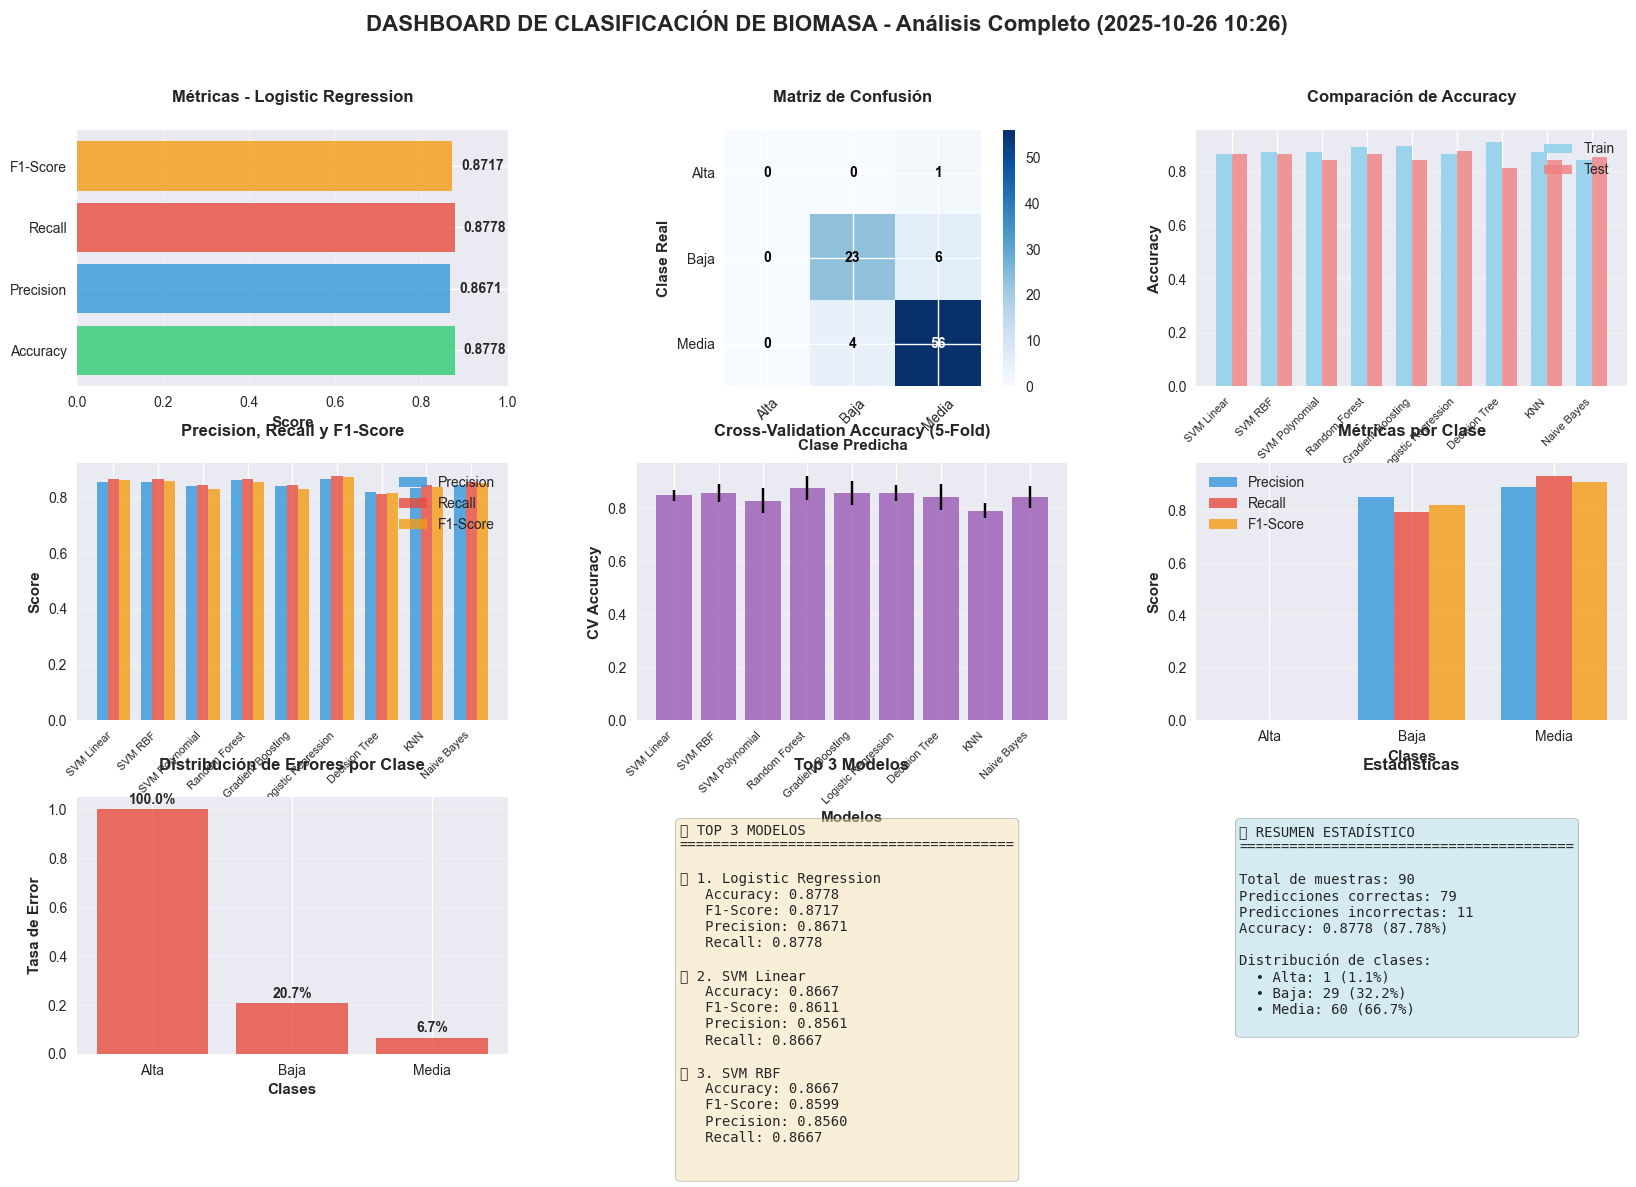

✓ Dashboard generado exitosamente


In [90]:
# Dashboard completo de resultados de clasificación
from datetime import datetime

# Crear figura con subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Métricas del mejor modelo (superior izquierda)
ax1 = fig.add_subplot(gs[0, 0])
metricas_best = [
    results_clf[best_model_name]['Accuracy_test'],
    results_clf[best_model_name]['Precision_test'],
    results_clf[best_model_name]['Recall_test'],
    results_clf[best_model_name]['F1_test']
]
labels_metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax1.barh(labels_metricas, metricas_best, color=colors, alpha=0.8)
ax1.set_xlim(0, 1)
ax1.set_xlabel('Score', fontweight='bold')
ax1.set_title(f'Métricas - {best_model_name}', fontsize=12, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)
for bar, value in zip(bars, metricas_best):
    ax1.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.4f}', 
             va='center', fontweight='bold', fontsize=10)

# 2. Matriz de Confusión (superior centro)
from sklearn.metrics import confusion_matrix
ax2 = fig.add_subplot(gs[0, 1])
cm = confusion_matrix(y_test, best_predictions)
im = ax2.imshow(cm, interpolation='nearest', cmap='Blues')
ax2.figure.colorbar(im, ax=ax2)
tick_marks = np.arange(len(le_target.classes_))
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(le_target.classes_, rotation=45)
ax2.set_yticklabels(le_target.classes_)
# Agregar valores en las celdas
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax2.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontweight='bold')
ax2.set_ylabel('Clase Real', fontweight='bold')
ax2.set_xlabel('Clase Predicha', fontweight='bold')
ax2.set_title('Matriz de Confusión', fontsize=12, fontweight='bold', pad=20)

# 3. Comparación de Accuracy (superior derecha)
ax3 = fig.add_subplot(gs[0, 2])
models = list(results_clf.keys())
accuracy_train = [results_clf[model]['Accuracy_train'] for model in models]
accuracy_test = [results_clf[model]['Accuracy_test'] for model in models]
x = np.arange(len(models))
width = 0.35
ax3.bar(x - width/2, accuracy_train, width, label='Train', alpha=0.8, color='skyblue')
ax3.bar(x + width/2, accuracy_test, width, label='Test', alpha=0.8, color='lightcoral')
ax3.set_xlabel('Modelos', fontweight='bold')
ax3.set_ylabel('Accuracy', fontweight='bold')
ax3.set_title('Comparación de Accuracy', fontsize=12, fontweight='bold', pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Precision, Recall y F1-Score por modelo (media izquierda)
ax4 = fig.add_subplot(gs[1, 0])
precision_test = [results_clf[model]['Precision_test'] for model in models]
recall_test = [results_clf[model]['Recall_test'] for model in models]
f1_test = [results_clf[model]['F1_test'] for model in models]
x = np.arange(len(models))
width = 0.25
ax4.bar(x - width, precision_test, width, label='Precision', alpha=0.8, color='#3498db')
ax4.bar(x, recall_test, width, label='Recall', alpha=0.8, color='#e74c3c')
ax4.bar(x + width, f1_test, width, label='F1-Score', alpha=0.8, color='#f39c12')
ax4.set_xlabel('Modelos', fontweight='bold')
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('Precision, Recall y F1-Score', fontsize=12, fontweight='bold', pad=20)
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Cross-Validation Accuracy (media centro)
ax5 = fig.add_subplot(gs[1, 1])
cv_accuracy_mean = [results_clf[model]['CV_Accuracy_mean'] for model in models]
cv_accuracy_std = [results_clf[model]['CV_Accuracy_std'] for model in models]
ax5.bar(x, cv_accuracy_mean, yerr=cv_accuracy_std, capsize=5, alpha=0.8, color='#9b59b6')
ax5.set_xlabel('Modelos', fontweight='bold')
ax5.set_ylabel('CV Accuracy', fontweight='bold')
ax5.set_title('Cross-Validation Accuracy (5-Fold)', fontsize=12, fontweight='bold', pad=20)
ax5.set_xticks(x)
ax5.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Métricas por clase (media derecha)
ax6 = fig.add_subplot(gs[1, 2])
from sklearn.metrics import precision_score, recall_score, f1_score
precision_per_class = precision_score(y_test, best_predictions, average=None)
recall_per_class = recall_score(y_test, best_predictions, average=None)
f1_per_class = f1_score(y_test, best_predictions, average=None)
classes = le_target.classes_
x_pos = np.arange(len(classes))
width = 0.25
ax6.bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8, color='#3498db')
ax6.bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8, color='#e74c3c')
ax6.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8, color='#f39c12')
ax6.set_xlabel('Clases', fontweight='bold')
ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Métricas por Clase', fontsize=12, fontweight='bold', pad=20)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(classes, fontsize=10)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 7. Distribución de errores (inferior izquierda)
ax7 = fig.add_subplot(gs[2, 0])
errores_por_clase = []
for i, clase in enumerate(le_target.classes_):
    class_errors = ((y_test == i) & (best_predictions != i)).sum()
    class_total = (y_test == i).sum()
    if class_total > 0:
        error_rate = class_errors / class_total
        errores_por_clase.append(error_rate)
    else:
        errores_por_clase.append(0)
ax7.bar(classes, errores_por_clase, alpha=0.8, color='#e74c3c')
ax7.set_xlabel('Clases', fontweight='bold')
ax7.set_ylabel('Tasa de Error', fontweight='bold')
ax7.set_title('Distribución de Errores por Clase', fontsize=12, fontweight='bold', pad=20)
ax7.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(errores_por_clase):
    ax7.text(i, v + 0.01, f'{v*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# 8. Top 3 modelos (inferior centro)
ax8 = fig.add_subplot(gs[2, 1])
ax8.axis('off')
top3_text = "🏆 TOP 3 MODELOS\n" + "="*40 + "\n\n"
for i, (model_name, metrics) in enumerate(results_sorted_clf.head(3).iterrows(), 1):
    medal = "🥇" if i == 1 else ("🥈" if i == 2 else "🥉")
    top3_text += f"{medal} {i}. {model_name}\n"
    top3_text += f"   Accuracy: {metrics['Accuracy_test']:.4f}\n"
    top3_text += f"   F1-Score: {metrics['F1_test']:.4f}\n"
    top3_text += f"   Precision: {metrics['Precision_test']:.4f}\n"
    top3_text += f"   Recall: {metrics['Recall_test']:.4f}\n\n"
ax8.text(0.1, 0.9, top3_text, transform=ax8.transAxes, fontsize=10,
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax8.set_title('Top 3 Modelos', fontsize=12, fontweight='bold', pad=20)

# 9. Resumen estadístico (inferior derecha)
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
total_samples = len(y_test)
correct_predictions = (y_test == best_predictions).sum()
incorrect_predictions = total_samples - correct_predictions
accuracy = correct_predictions / total_samples

resumen_text = "📊 RESUMEN ESTADÍSTICO\n" + "="*40 + "\n\n"
resumen_text += f"Total de muestras: {total_samples}\n"
resumen_text += f"Predicciones correctas: {correct_predictions}\n"
resumen_text += f"Predicciones incorrectas: {incorrect_predictions}\n"
resumen_text += f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n\n"
resumen_text += f"Distribución de clases:\n"
for i, clase in enumerate(le_target.classes_):
    count = (y_test == i).sum()
    percentage = (count / total_samples) * 100
    resumen_text += f"  • {clase}: {count} ({percentage:.1f}%)\n"

ax9.text(0.1, 0.9, resumen_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax9.set_title('Estadísticas', fontsize=12, fontweight='bold', pad=20)

# Título general del dashboard
fig.suptitle(f'DASHBOARD DE CLASIFICACIÓN DE BIOMASA - Análisis Completo ({datetime.now().strftime("%Y-%m-%d %H:%M")})', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("✓ Dashboard generado exitosamente")

## 11. Función de Predicción de Nuevos Datos desde Excel

In [91]:
def predecir_desde_excel_clasificacion(archivo_excel, nombre_hoja='Datos Nuevos'):
    """
    Carga datos nuevos desde un archivo Excel y realiza predicciones de clasificación
    
    Parámetros:
    -----------
    archivo_excel : str
        Ruta al archivo Excel con datos nuevos
    nombre_hoja : str
        Nombre de la hoja con los datos (por defecto 'Datos Nuevos')
    
    El archivo Excel debe contener las mismas columnas que se usaron para entrenar el modelo
    
    Retorna:
    --------
    DataFrame con predicciones y archivo Excel con resultados
    """
    
    try:
        # Cargar datos nuevos
        print(f"Cargando datos desde: {archivo_excel}")
        df_nuevo = pd.read_excel(archivo_excel, sheet_name=nombre_hoja)
        print(f"✓ Datos cargados: {df_nuevo.shape[0]} registros")
        
        # Verificar columnas requeridas
        columnas_requeridas = X_imputed.columns.tolist()
        columnas_faltantes = [col for col in columnas_requeridas if col not in df_nuevo.columns]
        
        if columnas_faltantes:
            print(f"❌ Error: Faltan las siguientes columnas:")
            for col in columnas_faltantes:
                print(f"   - {col}")
            return None
        
        # Preparar datos (mismas transformaciones que en entrenamiento)
        X_nuevo = df_nuevo[columnas_requeridas].copy()
        
        # Codificar variables categóricas si es necesario
        categorical_features = X_nuevo.select_dtypes(include=['object']).columns
        le_features_nuevo = LabelEncoder()
        for col in categorical_features:
            X_nuevo[col] = le_features_nuevo.fit_transform(X_nuevo[col].astype(str))
        
        # Imputar valores nulos con la misma estrategia
        imputer_nuevo = SimpleImputer(strategy='median')
        X_nuevo_imputed = pd.DataFrame(imputer_nuevo.fit_transform(X_nuevo), columns=X_nuevo.columns)
        
        # Escalar datos si el modelo lo requiere
        usa_escalado = best_model_name in ['SVM Linear', 'SVM RBF', 'SVM Polynomial', 'Logistic Regression', 'KNN', 'Naive Bayes']
        
        if usa_escalado:
            scaler_nuevo = StandardScaler()
            X_nuevo_scaled = scaler_nuevo.fit_transform(X_nuevo_imputed)
            X_procesado = X_nuevo_scaled
        else:
            X_procesado = X_nuevo_imputed
        
        # Realizar predicciones
        print("\nRealizando predicciones con {0}...".format(best_model_name))
        
        if hasattr(best_model, 'best_estimator_'):
            predicciones = best_model.best_estimator_.predict(X_procesado)
            if hasattr(best_model.best_estimator_, 'predict_proba'):
                probabilidades = best_model.best_estimator_.predict_proba(X_procesado)
        else:
            predicciones = best_model.predict(X_procesado)
            if hasattr(best_model, 'predict_proba'):
                probabilidades = best_model.predict_proba(X_procesado)
        
        # Decodificar predicciones
        clases_predichas = [le_target.classes_[i] for i in predicciones]
        
        # Crear DataFrame de resultados
        df_resultados = df_nuevo.copy()
        df_resultados['Clase_Predicha'] = clases_predichas
        df_resultados['Clase_Predicha_Codigo'] = predicciones
        
        # Agregar probabilidades si están disponibles
        if 'probabilidades' in locals():
            for i, clase in enumerate(le_target.classes_):
                df_resultados[f'Prob_{clase}'] = probabilidades[:, i]
        
        df_resultados['Modelo_Utilizado'] = best_model_name
        df_resultados['Fecha_Prediccion'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Guardar resultados en Excel
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        archivo_salida = f'Predicciones_Clasificacion_{timestamp}.xlsx'
        
        with pd.ExcelWriter(archivo_salida, engine='openpyxl') as writer:
            # Hoja 1: Predicciones completas
            df_resultados.to_excel(writer, sheet_name='Predicciones', index=False)
            
            # Hoja 2: Resumen estadístico
            resumen = pd.DataFrame({
                'Métrica': [
                    'Total de registros',
                    'Modelo utilizado',
                    'Fecha de predicción',
                    'Clases posibles',
                    '',
                    'Distribución de predicciones:',
                ],
                'Valor': [
                    len(df_resultados),
                    best_model_name,
                    datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    ', '.join(le_target.classes_),
                    '',
                    '',
                ]
            })
            
            # Agregar distribución de clases predichas
            for clase in le_target.classes_:
                count = (df_resultados['Clase_Predicha'] == clase).sum()
                percentage = (count / len(df_resultados)) * 100
                resumen = pd.concat([resumen, pd.DataFrame({
                    'Métrica': [f'  {clase}'],
                    'Valor': [f'{count} ({percentage:.1f}%)']
                })], ignore_index=True)
            
            resumen.to_excel(writer, sheet_name='Resumen', index=False)
            
            # Formatear hojas
            workbook = writer.book
            for sheet_name in workbook.sheetnames:
                worksheet = workbook[sheet_name]
                for column in worksheet.columns:
                    max_length = 0
                    column_letter = column[0].column_letter
                    for cell in column:
                        try:
                            if len(str(cell.value)) > max_length:
                                max_length = len(cell.value)
                        except:
                            pass
                    adjusted_width = min(max_length + 2, 50)
                    worksheet.column_dimensions[column_letter].width = adjusted_width
        
        print(f"\n✓ Predicciones completadas exitosamente")
        print(f"✓ Resultados guardados en: {archivo_salida}")
        print(f"\nDistribución de predicciones:")
        for clase in le_target.classes_:
            count = (df_resultados['Clase_Predicha'] == clase).sum()
            percentage = (count / len(df_resultados)) * 100
            print(f"  {clase}: {count} ({percentage:.1f}%)")
        
        return df_resultados, archivo_salida
        
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo {archivo_excel}")
        return None
    except Exception as e:
        print(f"❌ Error al procesar datos: {str(e)}")
        return None

# Función para crear archivo de ejemplo
def crear_excel_ejemplo_clasificacion():
    """Crea un archivo Excel de ejemplo para predicciones de clasificación"""
    
    # Generar datos de ejemplo
    np.random.seed(42)
    n_ejemplos = 10
    
    # Tomar algunos datos del conjunto de prueba como ejemplo
    indices_ejemplo = np.random.choice(X_test.index, size=min(n_ejemplos, len(X_test)), replace=False)
    datos_ejemplo = X_imputed.loc[indices_ejemplo].copy()
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'Datos_Nuevos_Ejemplo_Clasificacion_{timestamp}.xlsx'
    datos_ejemplo.to_excel(filename, sheet_name='Datos Nuevos', index=False)
    
    print(f"✓ Archivo de ejemplo creado: {filename}")
    print(f"  Contiene {len(datos_ejemplo)} registros de ejemplo")
    print(f"\nPara realizar predicciones, use:")
    print(f"  resultados, archivo = predecir_desde_excel_clasificacion('{filename}')")
    
    return filename

# Crear archivo de ejemplo
if 'X_imputed' in globals() and 'best_model' in globals():
    archivo_ejemplo = crear_excel_ejemplo_clasificacion()
else:
    print('⚠ Ejecute primero las celdas anteriores para entrenar el modelo')


✓ Archivo de ejemplo creado: Datos_Nuevos_Ejemplo_Clasificacion_20251026_102622.xlsx
  Contiene 10 registros de ejemplo

Para realizar predicciones, use:
  resultados, archivo = predecir_desde_excel_clasificacion('Datos_Nuevos_Ejemplo_Clasificacion_20251026_102622.xlsx')


## 12. Guardado del Modelo

In [92]:
import pickle
import joblib
import json

# Guardar el mejor modelo y objetos necesarios
def guardar_modelo_clasificacion():
    """
    Guarda el modelo entrenado, scaler, imputer y metadatos
    para uso posterior en producción
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("=" * 70)
    print("GUARDANDO MODELO PARA SISTEMA DE PREDICCIÓN EN EXCEL")
    print("=" * 70)
    
    # 1. Guardar el mejor modelo
    if hasattr(best_model, 'best_estimator_'):
        modelo_final = best_model.best_estimator_
    else:
        modelo_final = best_model
    
    joblib.dump(modelo_final, 'best_model_clasificacion.pkl')
    print(f"✓ Modelo guardado: best_model_clasificacion.pkl")
    
    # 2. Guardar el scaler (si se usó)
    usa_escalado = best_model_name in ['SVM Linear', 'SVM RBF', 'SVM Polynomial', 'Logistic Regression', 'KNN', 'Naive Bayes']
    
    if usa_escalado:
        scaler_guardado = StandardScaler()
        scaler_guardado.fit(X_train)
        joblib.dump(scaler_guardado, 'scaler_clasificacion.pkl')
        print(f"✓ Scaler guardado: scaler_clasificacion.pkl")
    
    # 3. Guardar el imputer
    imputer_guardado = SimpleImputer(strategy='median')
    imputer_guardado.fit(X_train)
    joblib.dump(imputer_guardado, 'imputer_clasificacion.pkl')
    print(f"✓ Imputer guardado: imputer_clasificacion.pkl")
    
    # 4. Guardar el LabelEncoder
    joblib.dump(le_target, 'label_encoder.pkl')
    print(f"✓ LabelEncoder guardado: label_encoder.pkl")
    
    # 5. Guardar metadatos
    metadata = {
        'modelo': best_model_name,
        'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'metricas': {
            'accuracy_test': float(results_sorted_clf.loc[best_model_name, 'Accuracy_test']),
            'precision_test': float(results_sorted_clf.loc[best_model_name, 'Precision_test']),
            'recall_test': float(results_sorted_clf.loc[best_model_name, 'Recall_test']),
            'f1_test': float(results_sorted_clf.loc[best_model_name, 'F1_test']),
            'cv_accuracy_mean': float(results_sorted_clf.loc[best_model_name, 'CV_Accuracy_mean']),
            'cv_accuracy_std': float(results_sorted_clf.loc[best_model_name, 'CV_Accuracy_std'])
        },
        'clases': le_target.classes_.tolist(),
        'variables_predictoras': X_imputed.columns.tolist(),
        'usa_escalado': usa_escalado,
        'parametros': best_model.best_params_ if hasattr(best_model, 'best_params_') else {}
    }
    
    with open('model_info_clasificacion.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadatos guardados: model_info_clasificacion.json")
    
    # 6. Crear backup del modelo completo
    backup_data = {
        'modelo': modelo_final,
        'scaler': scaler_guardado if usa_escalado else None,
        'imputer': imputer_guardado,
        'label_encoder': le_target,
        'metadata': metadata
    }
    
    backup_filename = f'modelo_clasificacion_backup_{timestamp}.pkl'
    joblib.dump(backup_data, backup_filename)
    print(f"✓ Backup completo guardado: {backup_filename}")
    
    print("\n" + "=" * 70)
    print("RESUMEN DE ARCHIVOS GUARDADOS:")
    print("=" * 70)
    archivos = [
        ("best_model_clasificacion.pkl", "Modelo entrenado"),
        ("scaler_clasificacion.pkl", "Escalador (si aplica)" if usa_escalado else "No aplica"),
        ("imputer_clasificacion.pkl", "Imputador de valores nulos"),
        ("label_encoder.pkl", "Codificador de clases"),
        ("model_info_clasificacion.json", "Metadatos y métricas"),
        (backup_filename, "Backup completo"),
    ]
    
    for archivo, descripcion in archivos:
        if descripcion != "No aplica":
            print(f"  • {archivo:<35} - {descripcion}")
    
    print("\n" + "=" * 70)
    print("PRÓXIMOS PASOS:")
    print("=" * 70)
    print("1. Ejecuta: python 2_crear_plantilla_excel_clasificacion.py")
    print("2. Llena los datos en el Excel generado")
    print("3. Ejecuta: python 3_predecir_en_excel_clasificacion.py")
    print("4. Abre el Excel para ver las predicciones")
    print("=" * 70)
    
    return 'best_model_clasificacion.pkl', 'scaler_clasificacion.pkl', 'model_info_clasificacion.json', backup_filename


# Guardar el modelo
if 'best_model' in globals() and 'best_model_name' in globals():
    archivos_guardados = guardar_modelo_clasificacion()
else:
    print('⚠ Ejecute primero las celdas anteriores para entrenar el modelo')


GUARDANDO MODELO PARA SISTEMA DE PREDICCIÓN EN EXCEL
✓ Modelo guardado: best_model_clasificacion.pkl
✓ Scaler guardado: scaler_clasificacion.pkl
✓ Imputer guardado: imputer_clasificacion.pkl
✓ LabelEncoder guardado: label_encoder.pkl
✓ Metadatos guardados: model_info_clasificacion.json
✓ Backup completo guardado: modelo_clasificacion_backup_20251026_102622.pkl

RESUMEN DE ARCHIVOS GUARDADOS:
  • best_model_clasificacion.pkl        - Modelo entrenado
  • scaler_clasificacion.pkl            - Escalador (si aplica)
  • imputer_clasificacion.pkl           - Imputador de valores nulos
  • label_encoder.pkl                   - Codificador de clases
  • model_info_clasificacion.json       - Metadatos y métricas
  • modelo_clasificacion_backup_20251026_102622.pkl - Backup completo

PRÓXIMOS PASOS:
1. Ejecuta: python 2_crear_plantilla_excel_clasificacion.py
2. Llena los datos en el Excel generado
3. Ejecuta: python 3_predecir_en_excel_clasificacion.py
4. Abre el Excel para ver las predicciones


## 13. Resumen Final y Generación de Archivos

In [93]:
# Generar resumen completo de archivos
def generar_resumen_archivos():
    """Genera un archivo de texto con resumen de todos los archivos generados"""
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename_resumen = f'RESUMEN_ARCHIVOS_{timestamp}.txt'
    
    archivos_info = []
    
    # 1. Modelo
    archivos_info.append({
        'categoria': '🤖 MODELO DE CLASIFICACIÓN',
        'archivos': [
            {
                'nombre': 'best_model_clasificacion.pkl',
                'descripcion': 'Modelo de clasificación entrenado',
                'tamaño': 'Variable según modelo'
            },
            {
                'nombre': 'model_info_clasificacion.json',
                'descripcion': 'Metadatos y métricas del modelo',
                'tamaño': 'Pocos KB'
            }
        ]
    })
    
    # 2. Reporte Excel
    if 'archivo_reporte' in globals():
        archivos_info.append({
            'categoria': '📊 REPORTE DE ANÁLISIS',
            'archivos': [
                {
                    'nombre': archivo_reporte,
                    'descripcion': 'Reporte completo con resultados (4 hojas)',
                    'tamaño': 'Variable'
                }
            ]
        })
    
    # 3. Archivos de ejemplo
    if 'archivo_ejemplo' in globals():
        archivos_info.append({
            'categoria': '📁 DATOS DE EJEMPLO',
            'archivos': [
                {
                    'nombre': archivo_ejemplo,
                    'descripcion': 'Plantilla con datos de ejemplo para predicciones',
                    'tamaño': 'Pocos KB'
                }
            ]
        })
    
    # Escribir resumen
    with open(filename_resumen, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("RESUMEN DE ARCHIVOS GENERADOS - CLASIFICACIÓN DE BIOMASA\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Fecha de generación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Mejor modelo: {best_model_name}\n")
        f.write(f"Accuracy: {results_sorted_clf.loc[best_model_name, 'Accuracy_test']:.4f}\n")
        f.write(f"F1-Score: {results_sorted_clf.loc[best_model_name, 'F1_test']:.4f}\n\n")
        
        for categoria_info in archivos_info:
            f.write(categoria_info['categoria'] + "\n")
            f.write("-" * 80 + "\n")
            for archivo in categoria_info['archivos']:
                f.write(f"  • {archivo['nombre']}\n")
                f.write(f"    {archivo['descripcion']}\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("CONTENIDO DE LOS ARCHIVOS:\n")
        f.write("=" * 80 + "\n\n")
        
        resumen_contenido = [
            ["Modelo (.pkl/.joblib)", "Modelo entrenado + Scaler + Imputer + LabelEncoder"],
            ["Metadatos (.json)", "Información del modelo, métricas y parámetros"],
            ["Reporte Excel", "4 hojas: Resumen, Comparación, Predicciones, Variables"],
            ["Datos Ejemplo", "Plantilla para nuevas predicciones"],
        ]
        
        max_width = max(len(row[0]) for row in resumen_contenido)
        for fila in resumen_contenido:
            f.write(f"  {fila[0]:<{max_width+5}} | {fila[1]}\n")
        
        f.write("\n" + "=" * 80 + "\n")
        f.write("💡 INSTRUCCIONES DE USO:\n")
        f.write("-" * 80 + "\n")
        f.write("""
  1. PARA REALIZAR NUEVAS PREDICCIONES:
     • Prepare un archivo Excel con las columnas requeridas
     • Use: predecir_desde_excel_clasificacion('su_archivo.xlsx')
     
  2. PARA CARGAR EL MODELO EN OTRA SESIÓN:
     • import joblib
     • modelo = joblib.load('best_model_clasificacion.pkl')
     • predicciones = modelo.predict(datos_nuevos)
     
  3. PARA REVISAR RESULTADOS:
     • Abra el archivo de reporte Excel
     • Revise cada hoja para análisis detallado
     
  4. PARA COMPARTIR EL MODELO:
     • Comparta los archivos .pkl y .json
     • Incluya la lista de variables predictoras
""")
        f.write("=" * 80 + "\n")
    
    print(f"✓ Resumen de archivos generado: {filename_resumen}")
    return filename_resumen

# Generar resumen
if 'best_model_name' in globals():
    archivo_resumen = generar_resumen_archivos()
    
    # Realizar predicciones de prueba
    if 'archivo_ejemplo' in globals():
        print("\n🔮 REALIZANDO PREDICCIONES DE PRUEBA...")
        print("-" * 70)
        resultados_prediccion, archivo_predicciones = predecir_desde_excel_clasificacion(archivo_ejemplo)
else:
    print('⚠ Ejecute primero las celdas anteriores para entrenar el modelo')


✓ Resumen de archivos generado: RESUMEN_ARCHIVOS_20251026_102622.txt

🔮 REALIZANDO PREDICCIONES DE PRUEBA...
----------------------------------------------------------------------
Cargando datos desde: Datos_Nuevos_Ejemplo_Clasificacion_20251026_102622.xlsx
✓ Datos cargados: 10 registros

Realizando predicciones con Logistic Regression...

✓ Predicciones completadas exitosamente
✓ Resultados guardados en: Predicciones_Clasificacion_20251026_102622.xlsx

Distribución de predicciones:
  Alta: 0 (0.0%)
  Baja: 4 (40.0%)
  Media: 6 (60.0%)
